In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import L2, L1
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_gen = ImageDataGenerator(validation_split = 0.1)

In [4]:
train_imgs = train_gen.flow_from_directory('Car-Bike-Dataset', target_size = (224, 224), classes = ['Bike', 'Car'], batch_size = 32, subset = 'training', shuffle = False)
test_imgs = train_gen.flow_from_directory('Car-Bike-Dataset', target_size = (224, 224), classes = ['Bike', 'Car'], batch_size = 1, subset = 'validation', shuffle = False)

Found 2761 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


### Model

In [5]:
mob = tf.keras.applications.MobileNetV3Small(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2023-03-01 09:00:14.223 tensorflow-2-6-gpu--ml-g4dn-xlarge-16c714feadc316564cf772a5f8d2:818 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-01 09:00:14.250 tensorflow-2-6-gpu--ml-g4dn-xlarge-16c714feadc316564cf772a5f8d2:818 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [6]:
mob.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [7]:
mob.trainable = False

In [9]:
model = Sequential()

x = GlobalAveragePooling2D()(mob.output)

out = Dense(2, activation = 'softmax')(x)

model = Model(inputs = mob.input, outputs = out)

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [11]:
cb = tf.keras.callbacks.ModelCheckpoint('mob_small.ckpt', save_weights_only = True, verbose = 1)

In [12]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'sgd', 
              metrics = ['accuracy'])

In [13]:
history = model.fit(train_imgs, epochs = 7, callbacks = [cb], validation_data = test_imgs)

Epoch 1/7
64/87 [=====================>........] - ETA: 3s - loss: 0.1801 - accuracy: 0.9477

/usr/local/lib/python3.8/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87/87 [==============================] - 19s 157ms/step - loss: 0.1519 - accuracy: 0.9573 - val_loss: 0.0691 - val_accuracy: 0.9902

Epoch 00001: saving model to mob_small.ckpt
Epoch 2/7
87/87 [==============================] - 12s 140ms/step - loss: 0.0495 - accuracy: 0.9895 - val_loss: 0.0460 - val_accuracy: 0.9935

Epoch 00002: saving model to mob_small.ckpt
Epoch 3/7
87/87 [==============================] - 12s 139ms/step - loss: 0.0363 - accuracy: 0.9935 - val_loss: 0.0374 - val_accuracy: 0.9935

Epoch 00003: saving model to mob_small.ckpt
Epoch 4/7
87/87 [==============================] - 12s 140ms/step - loss: 0.0299 - accuracy: 0.9942 - val_loss: 0.0324 - val_accuracy: 0.9935

Epoch 00004: saving model to mob_small.ckpt
Epoch 5/7
87/87 [==============================] - 12s 142ms/step - loss: 0.0259 - accuracy: 0.9957 - val_loss: 0.0289 - val_accuracy: 0.9935

Epoch 00005: saving model to mob_small.ckpt
Epoch 6/7
87/87 [==============================] - 12s 141ms/step - loss: 0

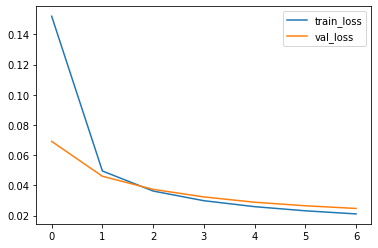

In [14]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

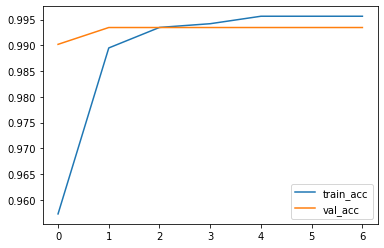

In [15]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [17]:
model.save('mob_small.h5')